In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.linalg import lstsq
from scipy.integrate import solve_ivp
from utils import *

In [2]:
# loading data
data_x0 = np.loadtxt('data/nonlinear_vectorfield_data_x0.txt')
data_x1 = np.loadtxt('data/nonlinear_vectorfield_data_x1.txt')

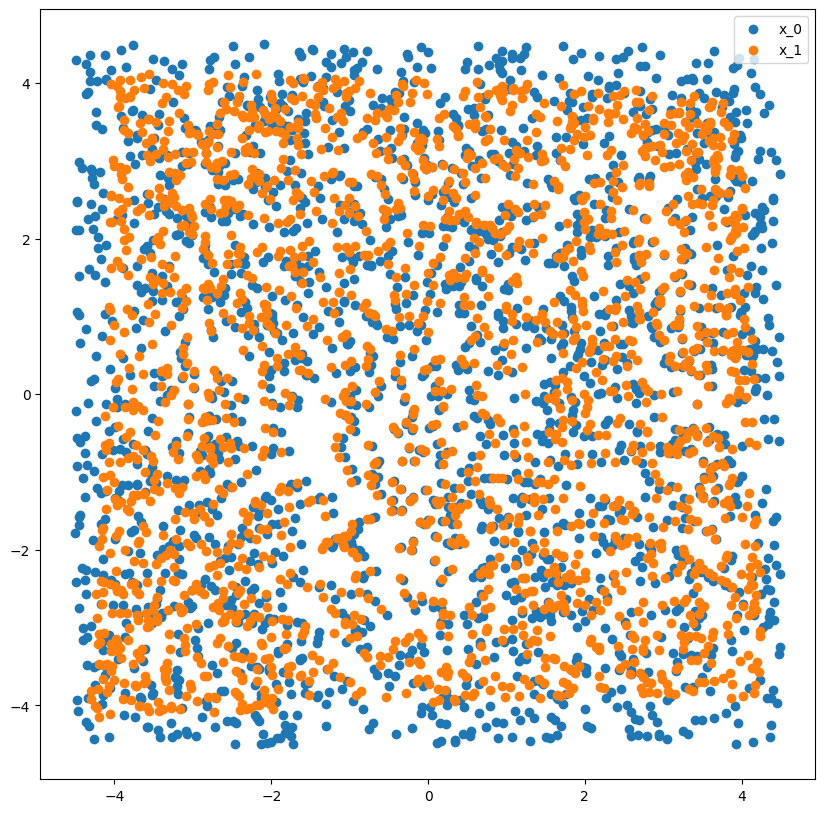

In [3]:
#plotting data
fig = plt.figure(figsize=(10,10))
plt.scatter(data_x0[:,0], data_x0[:,1], label="x_0")
plt.scatter(data_x1[:,0], data_x1[:,1], label="x_1")
plt.legend()
plt.show()

### Task 3.1

In [4]:
delta_t = 0.01
v_hat = estimate_vector(data_x0, data_x1,delta_t)
A_approximated = lstsq(data_x0, v_hat, cond=None)[0]

In [5]:
# Define linear approximation function
def linear_approximation(A, x0, delta_t):
    return x0 + delta_t * np.dot(A, x0.T)

In [6]:
# calculate mse
predicted_x1_all = np.array([linear_approximation(A_approximated, x0, delta_t) for x0 in data_x0])
mse_all = np.mean(np.square(data_x1 - predicted_x1_all))
print(f'Mean Squared Error: {mse_all}')

Mean Squared Error: 0.0186434856287006


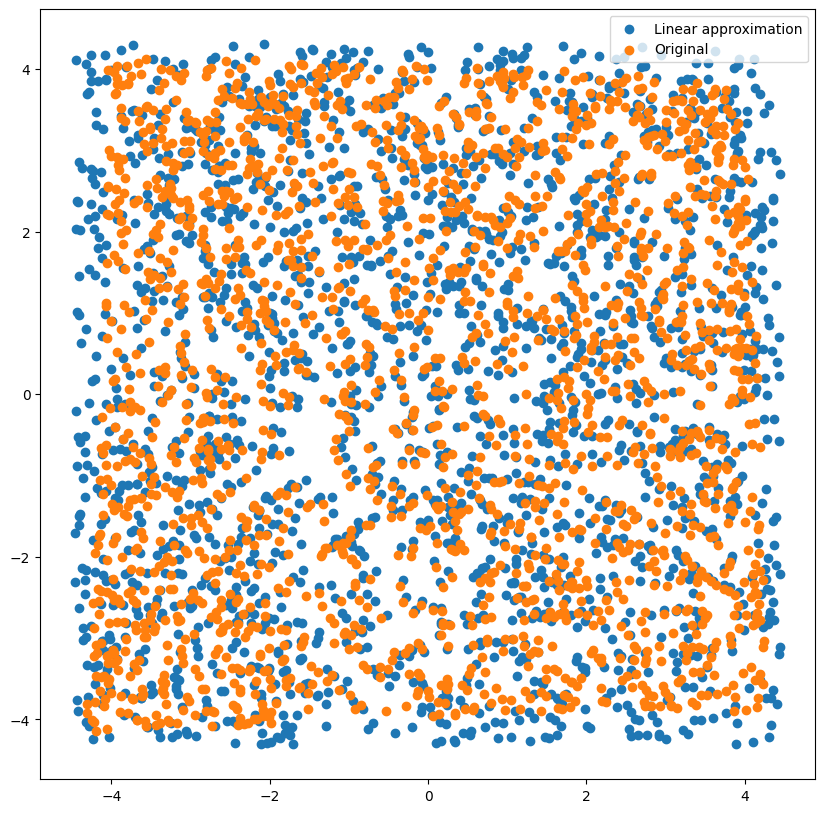

In [7]:
# plot approximated data
fig = plt.figure(figsize=(10,10))
plt.scatter(predicted_x1_all[:,0], predicted_x1_all[:,1], label="Linear approximation")
plt.scatter(data_x1[:,0], data_x1[:,1], label="Original")
plt.legend()
plt.show()

### Task 3.2

In [8]:
def radial_basis_function(data, l, eps):
    phi = []
    np.random.seed(42)
    x_l = np.random.choice(len(data), l, replace=False)

    for i in range(l):
        normalized_values = data - data[x_l[i]]
        phi_l = np.exp(-np.sum(normalized_values ** 2, axis=1) / eps ** 2)
        phi.append(phi_l)

    return np.array(phi).T  # Transpose to have shape (number of data points, number of RBFs)

In [9]:
# Approximate the vector field using RBF
def rbf_approximation(coefficients):
    return np.dot(phi, coefficients)

In [10]:
# find best combination of l and eps that yields lowest mse
larray = [800, 900, 1000]
epsarray = [1.5, 2, 2.5]
mse_rbf_array = []
mse_rbf_least = 10
eps_least = 0
l_least = 0

for l in larray:
    for eps in epsarray:
        
        phi = radial_basis_function(data_x0, l, eps)
        
        # Perform linear regression to estimate coefficients
        coefficients = lstsq(phi, v_hat, cond=None)[0]
        
        # Evaluate RBF approximation for all data points
        rbf_approximated_v = np.array(rbf_approximation(coefficients))

        # Calculate Mean Squared Error
        mse_rbf = np.mean(np.square(v_hat - rbf_approximated_v))
        mse_rbf_array.append((l, eps, mse_rbf))

        # Update if the current combination yields lower MSE
        if mse_rbf < mse_rbf_least:
            mse_rbf_least = mse_rbf
            eps_least = eps
            l_least = l
        
print(f'Least mean Squared Error (RBF): {mse_rbf_least} reached for: l={l_least}, eps={eps_least}')

Least mean Squared Error (RBF): 2.898361613586458e-12 reached for: l=1000, eps=2


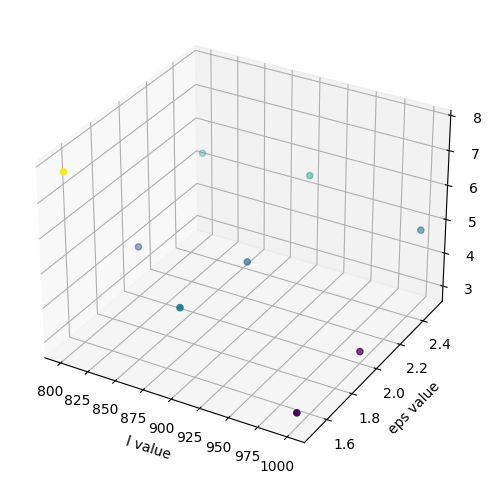

In [11]:
# comparison of l and eps values with their corresponding mse
l, eps, mse_rbf = zip(*mse_rbf_array)

# Convert to numpy arrays
l = np.array(l)
eps = np.array(eps)
mse_rbf = np.array(mse_rbf)

# Get unique values in l and eps
unique_l = np.unique(l)
unique_eps = np.unique(eps)

# Reshape to 2D arrays
l = l.reshape((len(unique_eps), len(unique_l)))
eps = eps.reshape((len(unique_eps), len(unique_l)))
mse_rbf = mse_rbf.reshape((len(unique_eps), len(unique_l)))

# Create a 3D plot
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

# Plot the points with colors based on mse_rbf values
scatter = ax.scatter(l, eps, mse_rbf, c=mse_rbf, cmap='viridis', marker='o')

# Set labels
ax.set_xlabel('l value')
ax.set_ylabel('eps value')
ax.set_zlabel('mse_rbf')
#ax.set_title('3D Surface Plot')

# Show the plot
plt.show()


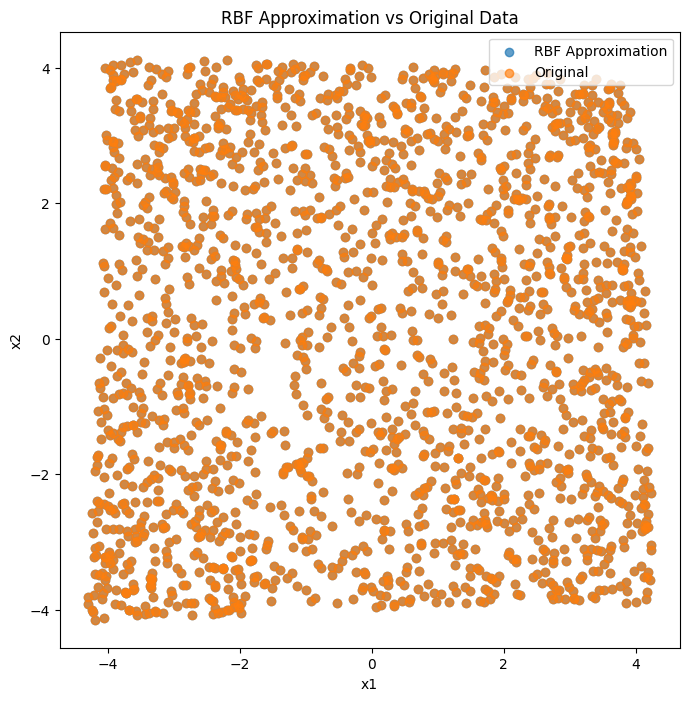

In [12]:
# Calculate approximation with optimal phi and eps
phi_optimal = radial_basis_function(data_x0, l_least, eps_least)
coefficients_optimal = lstsq(phi_optimal, v_hat, cond=None)[0]
rbf_approximated_v_x1 = np.dot(phi_optimal, coefficients_optimal)

def nonlinear_approximation(v_x1, x0, delta_t):
    return x0 + delta_t * v_x1

predicted_nonlinear = nonlinear_approximation(rbf_approximated_v_x1, data_x0, delta_t)

# Plot the RBF-approximated points
plt.figure(figsize=(8, 8))
plt.scatter(predicted_nonlinear[:, 0], predicted_nonlinear[:, 1], label='RBF Approximation', alpha=0.7)
plt.scatter(data_x1[:, 0], data_x1[:, 1], label='Original', alpha=0.7)
plt.title('RBF Approximation vs Original Data')
plt.xlabel('x1')
plt.ylabel('x2')
plt.legend()
plt.show()


### Task 3.3

In [13]:
t_final = 50  # Adjust as needed
delta_t = 0.01

In [14]:
def simulate_system(vector_field, initial_points, t_final, delta_t, coefficients, phi):
    t_span = (0, t_final)
    num_steps = int((t_final) / delta_t) + 1
    t_eval = np.linspace(0, t_final, num_steps)
    
    # Flatten all initial points
    initial_points_flattened = np.array([point.flatten() for point in initial_points])
    
    # Define a wrapper function for vector_field to handle flattened input
    def vector_field_wrapper(t, y, coefficients, phi):
        # Reshape y to match the original shape of initial_points
        y_reshaped = y.reshape((len(initial_points), 2))
        # Call the original vector_field function
        result = vector_field(t, y_reshaped.flatten(), coefficients, phi)
        # Return the result as a 1D array
        return result.flatten()
    
    # Solve the system for all initial points using the wrapper function
    sol = solve_ivp(vector_field_wrapper, y0=initial_points_flattened.flatten(), t_span=t_span, args=(coefficients, phi), t_eval=t_eval)
    
    # Reshape the solution to match the expected format
    solution = sol.y.reshape((len(initial_points), 2, len(t_eval)))

    return solution

def rbf_approximation_sim(t, y, coefficients, phi):
    # Assuming y is not used, modify as needed
    return phi @ coefficients

In [15]:
initial_points = data_x0

# Simulate the system using the RBF model
solution_rbf = simulate_system(rbf_approximation_sim, initial_points, t_final, delta_t, coefficients, phi)


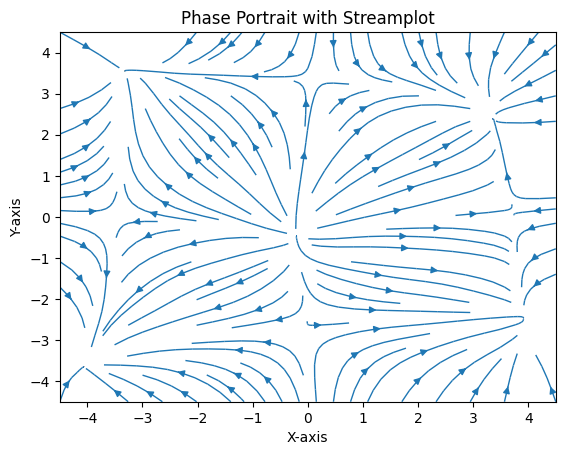

In [16]:
def radial_basis_function_vectorized(X, Y, l, eps, data):
    phi = np.zeros((len(X), len(Y), l))

    np.random.seed(42)
    x_l = np.random.choice(len(data), l, replace=False)

    for i in range(l):
        normalized_values_x = X - data[x_l[i], 0]
        normalized_values_y = Y - data[x_l[i], 1]

        phi[:, :, i] = np.exp(-(normalized_values_x**2 + normalized_values_y**2) / eps**2)

    return phi

# Generate a grid of points
x = np.linspace(-4.5, 4.5)
y = np.linspace(-4.5, 4.5)
X, Y = np.meshgrid(x, y)

# Calculate the radial basis function values for the grid
l = 1000  # Number of radial basis functions
eps = 2.0  # Adjust as needed
phi_values = radial_basis_function_vectorized(X, Y, l, eps, data_x0)

# Compute the vector field
U = np.sum(coefficients[:, 0] * phi_values, axis=2)
V = np.sum(coefficients[:, 1] * phi_values, axis=2)

# Plot the streamplot
plt.streamplot(X, Y, U, V, density=1, linewidth=1, arrowsize=1, cmap='autumn')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.title('Phase Portrait with Streamplot')
plt.show()
